In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#ml model
from sklearn.svm import SVC

In [2]:
#defining constants
image_size = 64
num_samples_per_class = 4000

In [3]:
#func to load and preprocess images
def load_data(folder, sample_count=None, label_filter=None):
    images = []
    labels = []
    filenames = []
    
    #a list of all filenames in the directory
    all_filenames = os.listdir(folder)
    random.shuffle(all_filenames)  #shuffle filenames

    cats_loaded = 0
    dogs_loaded = 0
    for filename in all_filenames:
        if 'cat' in filename:
            if cats_loaded >= num_samples_per_class:
                continue
            label = 0
            cats_loaded += 1
        elif 'dog' in filename:
            if dogs_loaded >= num_samples_per_class:
                continue
            label = 1
            dogs_loaded += 1
        else:
            continue

        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (image_size, image_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #converting to grayscale
        images.append(img)
        labels.append(label)
        filenames.append(filename)

        #stop if both classes have enough samples
        if cats_loaded >= num_samples_per_class and dogs_loaded >= num_samples_per_class:
            break

    images = np.array(images)
    labels = np.array(labels)

    #return a sample for visualization if needed
    if sample_count is not None:
        indices = np.random.choice(len(images), sample_count, replace=False)
        return images[indices], labels[indices]
    
    return images, labels, filenames

In [4]:
train_images, train_labels, filenames = load_data('/Task 3 prodigy internship/train')

In [5]:
#normalizing the images
train_images = train_images / 255.0

In [6]:
#reshaping the images for the SVM
train_images = train_images.reshape(train_images.shape[0], -1)

In [7]:
#checking unique classes in the labels
unique_classes = np.unique(train_labels)
print(f'Unique classes in the training labels: {unique_classes}')

Unique classes in the training labels: [0 1]


In [8]:
x_train, x_val, y_train, y_val, train_filenames, val_filenames = train_test_split(train_images, train_labels, filenames, test_size=0.2, random_state=42)

In [9]:
print(f'Unique classes in y_train: {np.unique(y_train)}')
print(f'Unique classes in y_val: {np.unique(y_val)}')

Unique classes in y_train: [0 1]
Unique classes in y_val: [0 1]


In [10]:
#training the SVM model
svm = SVC(kernel='linear', random_state=42)

In [11]:
svm.fit(x_train, y_train)

SVC(kernel='linear', random_state=42)

In [12]:
y_pred = svm.predict(x_val)

In [13]:
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.2f}')

Validation Accuracy: 0.52


In [14]:
print(classification_report(y_val, y_pred, target_names=['Cat', 'Dog']))

              precision    recall  f1-score   support

         Cat       0.52      0.57      0.54       797
         Dog       0.52      0.47      0.49       803

    accuracy                           0.52      1600
   macro avg       0.52      0.52      0.52      1600
weighted avg       0.52      0.52      0.52      1600



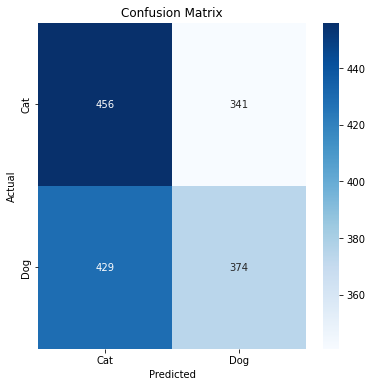

In [15]:
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [16]:
#a df with filenames and predicted labels
results = pd.DataFrame({
    'id': val_filenames,
    'label': y_pred
})

In [17]:
print(results)

                 id  label
0      dog.8534.jpg      1
1      cat.6107.jpg      1
2      cat.4206.jpg      0
3     dog.12056.jpg      1
4      dog.9508.jpg      1
...             ...    ...
1595   cat.1163.jpg      1
1596   cat.4654.jpg      0
1597   cat.9922.jpg      0
1598   dog.4223.jpg      1
1599   dog.3864.jpg      0

[1600 rows x 2 columns]


In [18]:
#loading test data
def load_test_data(folder):
    images = []
    filenames = []
    
    all_filenames = os.listdir(folder)
    for filename in all_filenames:
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (image_size, image_size))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #converting to grayscale
            images.append(img)
            filenames.append(filename)
    
    images = np.array(images)
    return images, filenames

In [19]:
test_dir = '/Task 3 prodigy internship/test1'

In [20]:
#loading and preprocess test images
test_images, test_filenames = load_test_data(test_dir)
test_images_flattened = test_images.reshape(test_images.shape[0], -1)

In [21]:
#predicting on test data
test_predictions = svm.predict(test_images_flattened)

In [22]:
#a df with filenames and predicted labels
test_results = pd.DataFrame({
    'id': test_filenames,
    'label': test_predictions
})
print(test_results.head())

          id  label
0      1.jpg      0
1     10.jpg      0
2    100.jpg      1
3   1000.jpg      0
4  10000.jpg      0


In [23]:
#func to manually test an image
def test_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #converting to grayscale
    img_flattened = img.reshape(1, -1)  #flatten the image
    prediction = svm.predict(img_flattened)
    label = 'Dog' if prediction[0] == 1 else 'Cat'
    
    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted Label: {label}')
    plt.axis('off')
    plt.show()
    
    return label

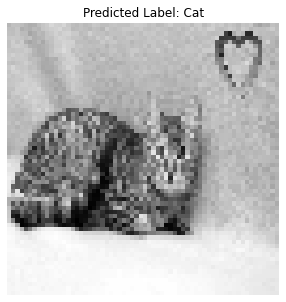

The predicted label for the selected image is: Cat


In [38]:
test_image_path = '/Task 3 prodigy internship/test1/237.jpg'  
predicted_label = test_image(test_image_path)
print(f'The predicted label for the selected image is: {predicted_label}')

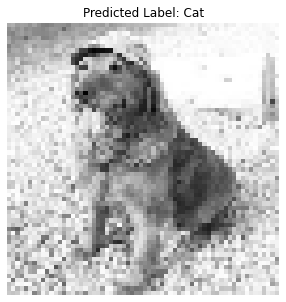

The predicted label for the selected image is: Cat


In [24]:
test_image_path = '/Task 3 prodigy internship/test1/10048.jpg'  
predicted_label = test_image(test_image_path)
print(f'The predicted label for the selected image is: {predicted_label}')

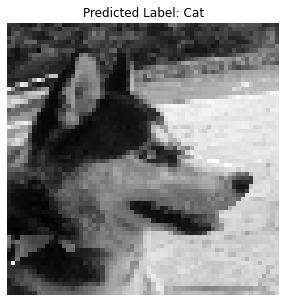

The predicted label for the selected image is: Cat


In [25]:
test_image_path = '/Task 3 prodigy internship/test1/892.jpg'  
predicted_label = test_image(test_image_path)
print(f'The predicted label for the selected image is: {predicted_label}')

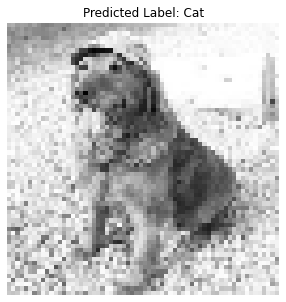

The predicted label for the selected image is: Cat


In [26]:
test_image_path = '/Task 3 prodigy internship/test1/10048.jpg'  
predicted_label = test_image(test_image_path)
print(f'The predicted label for the selected image is: {predicted_label}')

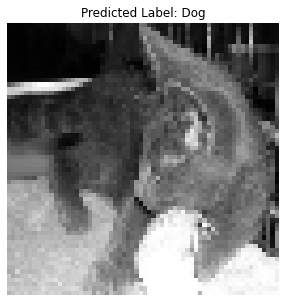

The predicted label for the selected image is: Dog


In [43]:
test_image_path = '/Task 3 prodigy internship/test1/100.jpg'  
predicted_label = test_image(test_image_path)
print(f'The predicted label for the selected image is: {predicted_label}')

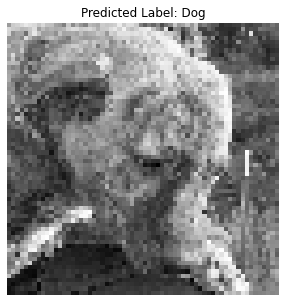

The predicted label for the selected image is: Dog


In [44]:
test_image_path = '/Task 3 prodigy internship/test1/10000.jpg'  
predicted_label = test_image(test_image_path)
print(f'The predicted label for the selected image is: {predicted_label}')

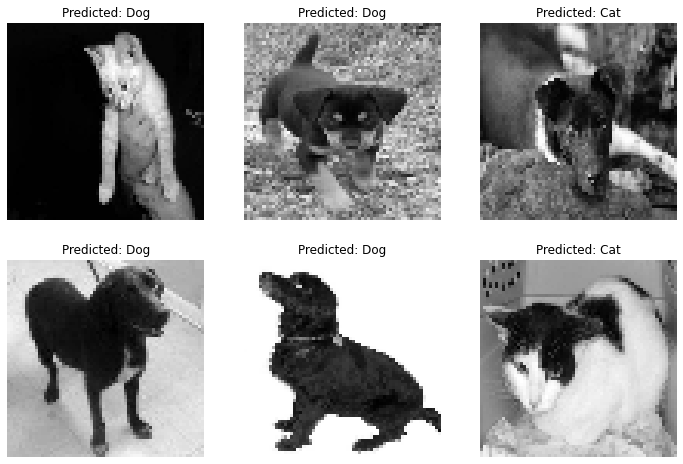

In [33]:
#func to display sample test images with predictions
def display_sample_predictions(test_images, test_filenames, predictions, num_samples=6):
    indices = np.random.choice(len(test_filenames), num_samples, replace=False)
    
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(indices):
        plt.subplot(2, 3, i + 1)
        plt.imshow(test_images[idx], cmap='gray')
        plt.title(f'Predicted: {"Dog" if predictions[idx] == 1 else "Cat"}')
        plt.axis('off')
    plt.show()

#displaying 6 random test images with their predicted labels
display_sample_predictions(test_images, test_filenames, test_predictions)